###House Price Prediction with PyTorch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error


In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [7]:
# ---------------------------
# 1. Data Loading and Preprocessing
# ---------------------------

# Load the dataset
file_path = '/content/house_price_dataset_not-clean.csv'
df = pd.read_csv(file_path)

def preprocess_data(df):
    # Handle missing values
    df['water_front'].fillna('No', inplace=True)
    df['room_size'].fillna(method='bfill', inplace=True)
    df['house_age'].fillna(method='ffill', inplace=True)
    df = df.dropna(subset=['front_garden', 'wall_fence'])

    # Convert measurements to numerical values
    df['land_size_sqm'] = df['land_size_sqm'].str.extract('(\d+)').astype(int)
    df['house_size_sqm'] = df['house_size_sqm'].str.extract('(\d+)').astype(int)
    df['distance_to_school'] = df['distance_to_school'].str.extract('(\d+)').astype(int)
    df['house_age'] = df['house_age'].str.extract('(\d+)').astype(int)
    df['distance_to_supermarket'] = df['distance_to_supermarket'].str.extract('(\d+)').astype(int)

    # One-hot encode categorical variables
    df = pd.get_dummies(df, columns=[
        'large_living_room', 'parking_space', 'front_garden',
        'swimming_pool', 'wall_fence', 'water_front', 'room_size'
    ])

    return df

df_clean = preprocess_data(df)



<ipython-input-7-71e64332bd47>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['water_front'].fillna('No', inplace=True)
<ipython-input-7-71e64332bd47>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [8]:
# ---------------------------
# 2. Prepare Data for Neural Network
# ---------------------------

# Separate features and target
X = df_clean.drop('property_value', axis=1).values
y = df_clean['property_value'].values.reshape(-1, 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test)

# Create DataLoader for batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [9]:
# ---------------------------
# 3. Build Neural Network Model
# ---------------------------

class HousePricePredictor(nn.Module):
    def __init__(self, input_size):
        super(HousePricePredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)

input_size = X_train_scaled.shape[1]
model = HousePricePredictor(input_size)
print(model)


HousePricePredictor(
  (network): Sequential(
    (0): Linear(in_features=24, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [10]:
# ---------------------------
# 4. Training Setup
# ---------------------------

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Early stopping
best_loss = float('inf')
patience = 10
patience_counter = 0


In [11]:
# ---------------------------
# 5. Train the Model
# ---------------------------

num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    val_loss = val_loss / len(test_loader.dataset)
    val_losses.append(val_loss)

    # Learning rate scheduler step
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))



Epoch 1/100 - Train Loss: 49277296011.1192, Val Loss: 46877182121.6323
Epoch 2/100 - Train Loss: 45197251089.5838, Val Loss: 35823814035.3939
Epoch 3/100 - Train Loss: 21898261630.1899, Val Loss: 9072808173.8990
Epoch 4/100 - Train Loss: 6900009894.0121, Val Loss: 5976016155.4101
Epoch 5/100 - Train Loss: 5918760636.2505, Val Loss: 5387643611.2808
Epoch 6/100 - Train Loss: 5510389698.9737, Val Loss: 4961095684.1374
Epoch 7/100 - Train Loss: 5053224688.4848, Val Loss: 4533380344.7596
Epoch 8/100 - Train Loss: 4649844210.5535, Val Loss: 4158357711.9030
Epoch 9/100 - Train Loss: 4335391150.2869, Val Loss: 3737568857.4707
Epoch 10/100 - Train Loss: 3965650797.1232, Val Loss: 3357565345.8747
Epoch 11/100 - Train Loss: 3510565539.9434, Val Loss: 2940592507.0869
Epoch 12/100 - Train Loss: 3157988945.4545, Val Loss: 2543024893.9313
Epoch 13/100 - Train Loss: 2753229139.2646, Val Loss: 2182788724.3636
Epoch 14/100 - Train Loss: 2422425371.1515, Val Loss: 1808345564.8323
Epoch 15/100 - Train Los

<All keys matched successfully>

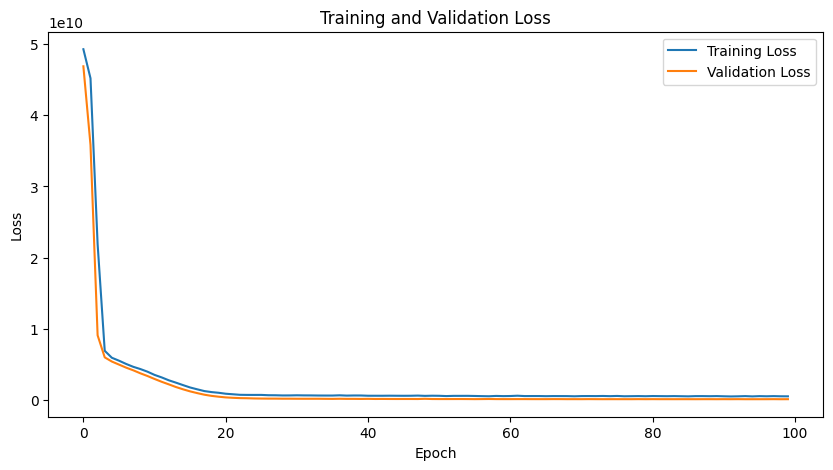

In [12]:
# ---------------------------
# 6. Evaluate the Model
# ---------------------------

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()



In [13]:
# Make predictions
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
y_pred = y_pred_tensor.numpy().flatten()
y_test_np = y_test_tensor.numpy().flatten()

# Calculate metrics
mse = mean_squared_error(y_test_np, y_pred)
r2 = r2_score(y_test_np, y_pred)
mape = mean_absolute_percentage_error(y_test_np, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')
print(f'Mean Absolute Percentage Error: {mape:.4f}')


Mean Squared Error: 92701616.00
R-squared: 0.99
Mean Absolute Percentage Error: 0.0432


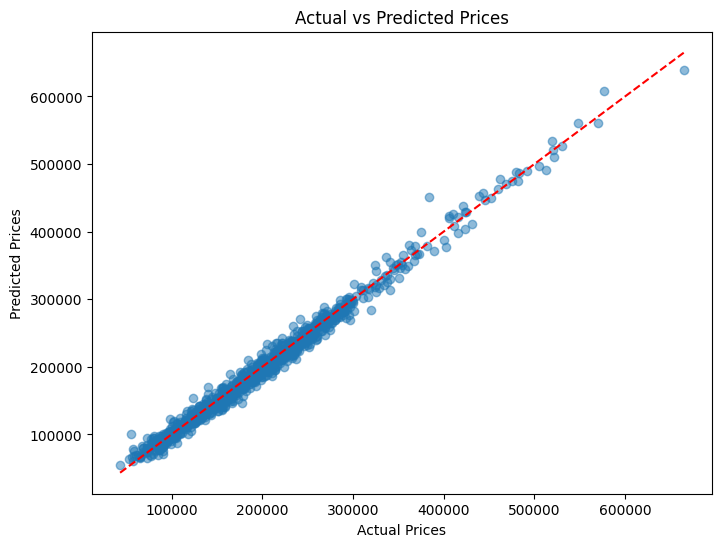

In [15]:
# ---------------------------
# 7. Visualization
# ---------------------------

# Actual vs Predicted Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test_np, y_pred, alpha=0.5)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()


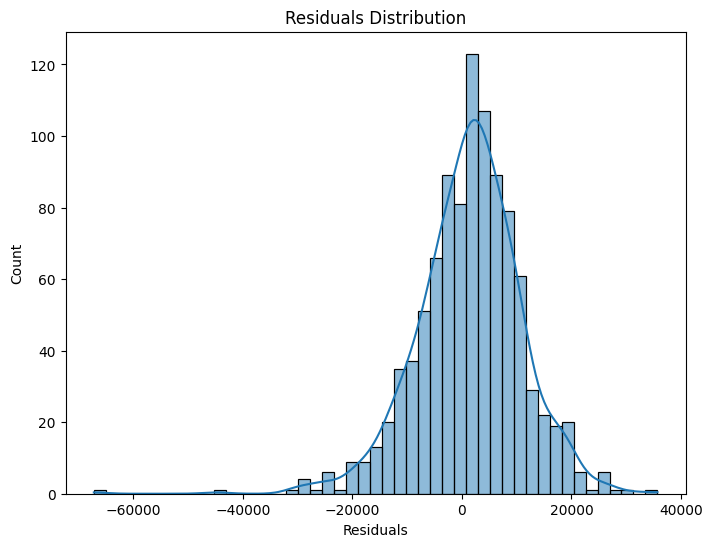

In [16]:
# Residuals distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Residuals Distribution')
plt.show()


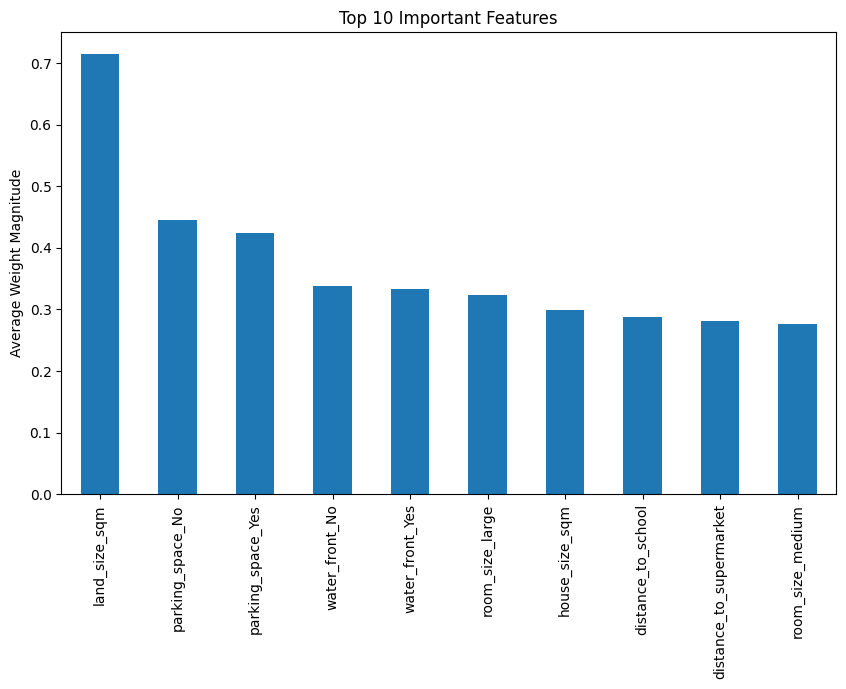

In [17]:
# ---------------------------
# 8. Feature Importance (Optional)
# ---------------------------

# Get weights from the first layer
weights = model.network[0].weight.data.numpy()
feature_importance = pd.Series(np.abs(weights).mean(axis=0), index=df_clean.drop('property_value', axis=1).columns)
top_features = feature_importance.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_features.plot(kind='bar')
plt.title('Top 10 Important Features')
plt.ylabel('Average Weight Magnitude')
plt.show()